# NumberGenerator

## Introduction

This program will generate handwritten numbers.

In [1]:
# Import Packages

from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot

In [2]:
# Define GAN architecture and training procedure

def define_discriminator(in_shape=(28,28,1)):
    """
    Defines the standalone discriminator architecture and creates associated model.
    
    ==Input==
      in_shape: the dimensions of the input images, plus a grayscale channel.
    
    ==Output
      Keras model object representing discriminator.
    """
    model = Sequential()
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    opt = Adam(learning_rate=0.0002, beta_1=0.5)   
    
    # Compile model using the above structure and optimizer.
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model


def define_generator(latent_dim):
    """
    Defines the standalone generator architecture and creates associated model.
    
    ==Input==
      latent_dim: the number of elements in the latent space vector (gaussian random numbers).
    
    ==Output
      Keras model object representing standalone generator.
    """    
    model = Sequential()
    
    # Set n_nodes equal to a low-resolution version of the output image (e.g. 7*7 instead of 24*24),
    #    multiplied by another number to generate many different versions of output image (e.g. 128).
    n_nodes = 128 * 7 * 7
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    
    # Reshape Dense layer to produce 128 various 7*7 feature maps.
    model.add(Reshape((7, 7, 128)))
    
    # Upsample to 14x14.
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    # Upsample to 28x28.
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    # Set output values in the range of [0,1].
    model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
    return model


def define_gan(g_model, d_model):
    """
    Combines the generator and discrimantor model in order to properly update generator weights.
    
    ==Input==
      g_model: the generator model, as created by define_generator.
      d_model: the discriminator model, as created by define_discriminator.
      
    ==Output==
      Keras model object representing combined generator and discriminator.
    """
    # For the combined model, set the discriminator as not trainable.
    d_model.trainable = False
    
    # Stack and combine models.
    model = Sequential()    
    model.add(g_model)
    model.add(d_model)
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model


def load_real_samples():
    """
    Loads the MNIST dataset and creates an array contained all data.
    
    ==Input==
      none.
      
    ==Output==
      X: a 3D array of the full dataset representing pixel positions and a grayscale channel.
    """
    # Load the MNIST Handwritten Digits dataset using the imported load_data function.
    (trainX, _), (_, _) = load_data()
    
    # Add a dimension for the grayscale channel.
    X = expand_dims(trainX, axis=-1)
    
    # Convert to floats and scale from [0,255] to [0,1].
    X = X.astype('float32')
    X = X / 255.0
    return X


def generate_real_samples(dataset, n_samples):
    """
    Takes a number of datapoints from the dataset as samples and classifies them as real.
    
    ==Input==
      dataset: a full 3D array of the handwritten numbers dataset, as returned by load_real_samples.
    
    ==Output==
      X: a 3D array of a sample from the dataset representing pixel positions and a grayscale channel.
      y: an array of ones corresponding to a "real" classification of the data.
    """
    # Randomly generates numbers with which to sample the dataset.
    ix = randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    
    y = ones((n_samples, 1))
    return X, y


def generate_latent_points(latent_dim, n_samples):
    """
    Generates datapoints in latent space as input for the generator.
    
    ==Input==
      latent_dim: the number of elements in the latent space vector (gaussian random numbers).
      n_samples: the number of points to generate from the latent space.
    
    ==Output==
      x_input: input for the generator consisting of a batch of inputs for the network.
    """
    # Generate points and reshape for the network.
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input


def generate_fake_samples(g_model, latent_dim, n_samples):
    """
    Utilize the latent points data to generate fake samples.
    
    ==Input==
      g_model: the standalone generator model, as returned by define_generator.
      latent_dim: the number of elements in the latent space vector (gaussian random numbers).
      n_samples: the number of points to generate from the latent space.
    
    ==Output==
      X: a 3D array of samples from the dataset representing pixel positions and a grayscale channel.
      y: an array of zeros corresponding to a "fake" classification of the data.
    """
    x_input = generate_latent_points(latent_dim, n_samples)
    
    # Predict outputs and assign "fake" classification labels.
    X = g_model.predict(x_input)
    y = zeros((n_samples, 1))
    return X, y


def save_plot(examples, epoch, n=10):
    """
    Save plots of the generated numbers to evaluate progress periodically.
    
    ==Input==
      examples: a 3D array of generated handwritten nubmers.
      epoch: the corresponding epoch from which the examples were obtained.
      n: the dimensions of the plot (n * n)
    
    ==Output==
      A .png file saved in the local directory containing the generated numbers.
    """
    # Plot images.
    for i in range(n * n):
        pyplot.subplot(n, n, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')

    filename = 'generated_plot_e%03d.png' % (epoch+1)
    pyplot.savefig(filename)
    pyplot.close()

    
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    """
    Measures the performance of the models by evaluating accuracy and saving images for review.
    
    ==Input==
      epoch: the current epoch number when this function is called.
      g_model: the standalone generator model.
      d_model: the standalone discriminator model.
      dataset: a full 3D array of the handwritten numbers dataset, as returned by load_real_samples.
      latent_dim: the number of elements in the latent space vector (gaussian random numbers).
      n_samples: the number of samples to evaluate the model's performance over.
    
    ==Output==
      Prints accuracy statistics during model training.
      Saves plots of generated numbers for review, as per the save_plot function.
      Periodically saves generator model .h5 files.      
    """
    # Retrieve real samples and evaluate discriminator.
    X_real, y_real = generate_real_samples(dataset, n_samples)
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    
    # Generate fake samples and evaluate discriminator.
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    
    # Summarize discriminator performance.
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    
    # Save associated plots.
    save_plot(x_fake, epoch)
    
    # Save the generator_model.h5 file
    filename = 'generator_model_%03d.h5' % (epoch + 1)
    g_model.save(filename)

    
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
    """
    Trains the generator and the discriminator.
    
    ==Input==
      g_model: the standalone generator model.
      d_model: the standalone discriminator model.    
      gan_model: the combined generator-discriminator model.
      dataset: a full 3D array of the handwritten numbers dataset, as returned by load_real_samples.
      latent_dim: the number of elements in the latent space vector (gaussian random numbers).
      n_epochs: the number of epochs to train over.
      n_batch: the batch size for each epoch.
    ==Output==
      Trains the Keras models and periodically returns the summary metrics from summarize_performance.
    """
    # Calculate number of batches per epoch.
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)

    # Manually iterate over epochs and batches.
    for i in range(n_epochs):
        for j in range(bat_per_epo):            
            # For each batch, make the training data half real and half fake.
            X_real, y_real = generate_real_samples(dataset, half_batch)
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
            
            # Update discriminator model weights.
            d_loss, _ = d_model.train_on_batch(X, y)
            
            # Prepare generator input from latent space.
            X_gan = generate_latent_points(latent_dim, n_batch)
            
            # Invert the classification labels for the fake samples so the combined model will
            #     properly train the generator.
            y_gan = ones((n_batch, 1))
            
            # Update the generator via the discriminator's error.
            g_loss = gan_model.train_on_batch(X_gan, y_gan)

        # Evaluate the model's performance periodically
        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [ ]:
# Prepare starting parameters, models, and data.
latent_dim = 100
d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)
dataset = load_real_samples()

# Train the model!
train(g_model, d_model, gan_model, dataset, latent_dim)

# Loading a saved model to generate

In [14]:
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot


def show_plot(examples, n):
    """
    Shows a plot of generated numbers based on a trained model file.
    
    ==Input==
      examples: a 3D array of generated handwritten nubmers.
      n: the dimensions of the plot (n * n)
    
    ==Output==
      A pyplot displayed in this notebook showing the generated numbers.
    """
    # Plot images.
    for i in range(n * n):
        pyplot.subplot(n, n, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')

    pyplot.show()   

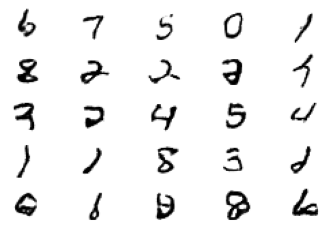

In [15]:
model = load_model('generator_model_100.h5', compile=False)

# Modify n_samples to change plot dimensions
n_samples = 5
latent_points = generate_latent_points(100, n_samples ** 2)
X = model.predict(latent_points)

show_plot(X, n_samples)

# Generate a single handwritten digit

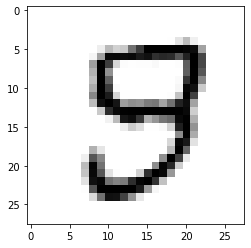

In [217]:
from keras.models import load_model
from numpy import asarray
from numpy.random import random
from matplotlib import pyplot

model = load_model('generator_model_100.h5', compile=False)

# Create random latent space array.
vector = asarray([[random() for _ in range(100)]])

X = model.predict(vector)

pyplot.imshow(X[0, :, :, 0], cmap='gray_r')
pyplot.show()